In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binom
import upsetplot

In [2]:
def get_df(spec_dict):

  lemur_mouse_conv = pd.read_csv("../utility_files/human_mouse_lemur_gene_name_conversion.txt",sep="\t")[["Mouse gene name","Human Gene name", "Mouse Lemur gene name"]]
  lemur_mouse_conv.loc[lemur_mouse_conv["Mouse Lemur gene name"].isna(),"Mouse Lemur gene name"] = lemur_mouse_conv.loc[lemur_mouse_conv["Mouse Lemur gene name"].isna(),"Human Gene name"]
  lemur_mouse_conv.loc[lemur_mouse_conv["Mouse gene name"].isna(),"Mouse gene name"] = lemur_mouse_conv.loc[lemur_mouse_conv["Mouse gene name"].isna(),"Human Gene name"].str.capitalize()
  # lemur_mouse_conv = lemur_mouse_conv.dropna(subset=["Mouse gene name"])

  mouse_conv_dict = pd.Series(lemur_mouse_conv["Human Gene name"].values,index=lemur_mouse_conv["Mouse gene name"]).to_dict()

  # lemur_mouse_conv = pd.read_csv("/oak/stanford/groups/horence/Roozbeh/single_cell_project/utility_files/human_mouse_lemur_gene_name_conversion.txt",sep="\t")

  # lemur_mouse_conv = lemur_mouse_conv.dropna(subset=["Mouse Lemur gene name"])
  lemur_conv_dict = pd.Series(lemur_mouse_conv["Human Gene name"].values,index=lemur_mouse_conv["Mouse Lemur gene name"]).to_dict()


  allgenes = {x : set() for x in spec_dict.keys()}
  siggenes = {x : set() for x in spec_dict.keys()}


  for organism, org_dnames in spec_dict.items():
    for dataname in org_dnames:
      var_df = pd.read_csv("../data/{}_pvals_ontology-dummy_100_S_0.1_z_0.0_b_5_sig.tsv".format(dataname),sep="\t")

      if organism == "mouse":
        var_df["geneR1A_uniq"] = var_df["geneR1A_uniq"].map(mouse_conv_dict)
      elif organism == "lemur": 
        var_df["geneR1A_uniq"] = var_df["geneR1A_uniq"].map(lemur_conv_dict)
      allgenes[organism].update(var_df["geneR1A_uniq"])
      siggenes[organism].update(var_df[var_df["sig"]]["geneR1A_uniq"])
  out = {"gene" : []}
  for org in spec_dict.keys():
    out["ever_sig_" + org] = []
  #   out["present_" + org] = []
  for gene in set.union(*allgenes.values()):
  #   if gene == "MYL6":
  #     break
    out["gene"].append(gene)
    for org in spec_dict.keys():
      if gene not in allgenes[org]:
        out["ever_sig_" + org].append(np.nan)
      elif gene in siggenes[org]:
        out["ever_sig_" + org].append(True)
      else:
        out["ever_sig_" + org].append(False)
  #     if gene in allgenes[org]:
  #       out["present_" + org].append(True)
  #     else:
  #       out["present_" + org].append(False)
  df = pd.DataFrame.from_dict(out)
  return df

In [3]:
def get_num_genes(df, inc_human, inc_mouse, inc_lemur):
    return df[(df["ever_sig_human"] == inc_human) &(df["ever_sig_mouse"] == inc_mouse) &(df["ever_sig_lemur"] == inc_lemur)]["gene"].nunique()

In [4]:
def get_num_genes_mouse(df, inc_human, inc_mouse):
    return df[(df["ever_sig_human"] == inc_human) &(df["ever_sig_mouse"] == inc_mouse) ]["gene"].nunique()

In [5]:
def get_num_genes_lemur(df, inc_human, inc_lemur):
    return df[(df["ever_sig_human"] == inc_human) &(df["ever_sig_lemur"] == inc_lemur) ]["gene"].nunique()

In [6]:
spec_dict = {"human" : ["TSP1_10x_with_postprocessing_nopanc_cellann","TSP2_10x_rerun_with_postprocessing_3prime_cellann",],
            "lemur" : ["Lemur_10x_Stumpy_with_postprocessing_cellann","Lemur_10x_Antoine_with_postprocessing_cellann"],
            "mouse" : ["Tabula_muris_senis_P1_10x_with_postprocessing_cellann","Tabula_muris_senis_P2_10x_with_postprocessing_cellann"]}

In [7]:
outpath = "output/upset_significant/"

In [8]:
# df = pd.read_csv("/scratch/PI/horence/JuliaO/single_cell/Differential_Splicing/notebooks/output/Biology_paper_numbers/merged_species_0.1.tsv",sep="\t")
df = get_df(spec_dict)

/home/users/jolivier/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [9]:
df[(df["ever_sig_human"] == True) & (df["ever_sig_lemur"] == True) & (df["ever_sig_mouse"] == True)]["gene"].unique()

array(['RPS24', 'RBM39', 'TPM1'], dtype=object)

In [10]:
species = ["human","mouse","lemur"]


In [11]:
df = df.dropna()

In [12]:
p_sig = []
for s in species:
  p_sig.append(df["ever_sig_" + s].value_counts()[True]/df["ever_sig_" + s].value_counts().sum())

In [14]:
sets = []
data = []
for inc_human in [True,False]:
  for inc_mouse in [True,False]:
    for inc_lemur in [True,False]:
      curr_set = []
      if inc_human:
        curr_set.append("human")
      if inc_mouse:
        curr_set.append("mouse")
      if inc_lemur:
        curr_set.append("lemur")
      sets.append(curr_set)
      data.append(get_num_genes(df, inc_human, inc_mouse, inc_lemur))
      

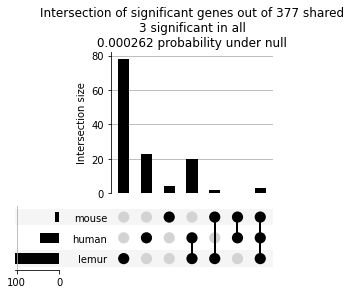

In [15]:
upset_input = upsetplot.from_memberships(sets[:-1],data=data[:-1])
upsetplot.plot(upset_input)
plt.title("Intersection of significant genes out of {} shared\n{} significant in all\n{:.3} probability under null".format(df.shape[0],data[0],1 - binom.cdf(get_num_genes(df,True,True,True), df.shape[0], p_sig[0]*p_sig[1]*p_sig[2])))
plt.savefig("{}upset_human_mouse_lemur.png".format(outpath),bbox_inches="tight")
plt.show()


## Just two human and mouse

In [16]:
# df = pd.read_csv("/scratch/PI/horence/JuliaO/single_cell/Differential_Splicing/notebooks/output/Biology_paper_numbers/merged_species_0.05.tsv",sep="\t")
df = get_df(spec_dict)

In [17]:
species = ["human","mouse"]



In [18]:
# df = df[["gene"] + ["max_mz_" + x for x in species] + ["tissue_" + x for x in species] + 
#         ["free_annotation_" + x for x in species] + ["ever_sig_" + x for x in species]]
df = df[["gene"] + ["ever_sig_" + x for x in species]]

In [19]:
df = df.dropna()

In [20]:
p_sig = []
for s in species:
  p_sig.append(df["ever_sig_" + s].value_counts()[True]/df["ever_sig_" + s].value_counts().sum())

In [21]:
p_sig[0]*p_sig[1]

0.002845343392299688

In [22]:
sets = []
data = []
for inc_human in [True,False]:
  for inc_mouse in [True,False]:

    curr_set = []
    if inc_human:
      curr_set.append("human")
    if inc_mouse:
      curr_set.append("mouse")

    sets.append(curr_set)
    data.append(get_num_genes_mouse(df, inc_human, inc_mouse))
      

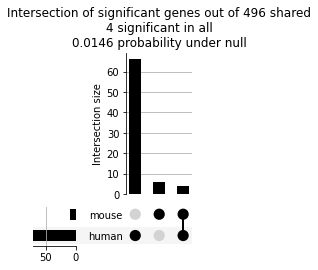

In [23]:
upset_input = upsetplot.from_memberships(sets[:-1],data=data[:-1])
upsetplot.plot(upset_input)
plt.title("Intersection of significant genes out of {} shared\n{} significant in all\n{:.3} probability under null".format(df.shape[0],data[0],1 - binom.cdf(get_num_genes_mouse(df,True,True), df.shape[0], p_sig[0]*p_sig[1])))
plt.savefig("{}upset_human_mouse.png".format(outpath),bbox_inches="tight")
plt.show()


## Just human and lemur

In [24]:
# df = pd.read_csv("/scratch/PI/horence/JuliaO/single_cell/Differential_Splicing/notebooks/output/Biology_paper_numbers/merged_species_0.05.tsv",sep="\t")
df = get_df(spec_dict)
species = ["human","lemur"]


In [25]:
# df = df[["gene"] + ["max_mz_" + x for x in species] + ["tissue_" + x for x in species] + 
#         ["free_annotation_" + x for x in species] + ["ever_sig_" + x for x in species]]
df = df[["gene"] + ["ever_sig_" + x for x in species]]
df = df.dropna()

In [26]:
p_sig = []
for s in species:
  p_sig.append(df["ever_sig_" + s].value_counts()[True]/df["ever_sig_" + s].value_counts().sum())

In [27]:
p_sig[0]*p_sig[1]

0.027724293158531966

In [28]:
sets = []
data = []
for inc_human in [True,False]:
  for inc_lemur in [True,False]:

    curr_set = []
    if inc_human:
      curr_set.append("human")
    if inc_lemur:
      curr_set.append("lemur")

    sets.append(curr_set)
    data.append(get_num_genes_lemur(df, inc_human, inc_lemur))
      

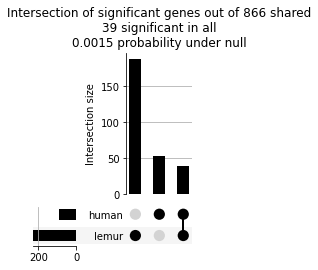

In [29]:
upset_input = upsetplot.from_memberships(sets[:-1],data=data[:-1])
upsetplot.plot(upset_input)
plt.title("Intersection of significant genes out of {} shared\n{} significant in all\n{:.3} probability under null".format(df.shape[0],data[0],1 - binom.cdf(get_num_genes_lemur(df,True,True), df.shape[0], p_sig[0]*p_sig[1])))
plt.savefig("{}upset_human_lemur.png".format(outpath),bbox_inches="tight")
plt.show()
